In [1]:
import csv
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#import plotly.express as px
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split #splitting the dataset
from sklearn.metrics import mean_absolute_error,mean_squared_error,confusion_matrix,r2_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn import svm
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score,precision_score
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report,plot_precision_recall_curve, average_precision_score, precision_recall_curve
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy import stats
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu, normaltest
#!pip install statannotations
from statannotations.Annotator import Annotator
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from bioinfokit.visuz import cluster
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from IPython.display import Image
#from pydotplus import graph_from_dot_data
from sklearn.feature_selection import SelectFromModel
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import KFold
import pickle
import joblib
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.optimize import curve_fit
import optuna
from scipy.stats import sem, t
#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
#Python standard libraries
import time
from tabpfn import TabPFNClassifier
import warnings
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200
%matplotlib inline


In [2]:
#data imports
data_train_df = pd.read_csv("../paper_analysis/IDT_Reps_BED_BAM_TPFP_Final_01312023.csv")

#data_test_df = pd.read_csv("rearranged_annotated_fixed_sorted_NGS82-VE070_dedup.combined.metrics.csv")

In [3]:
#create the class labels
data_train_df = data_train_df[~data_train_df['eight_and_GIAB'].isna()]
data_train_df = data_train_df.fillna(0)
data_train_df = data_train_df.reset_index(drop=True)
data_train_df['Class'] = data_train_df['eight_and_GIAB'].map({True : 0, False: 1})
data_train_df.Class.value_counts()

0    34772
1     5697
Name: Class, dtype: int64

In [4]:
#balance the data
class_0_df = data_train_df[data_train_df['Class'] == 0]
class_1_df = data_train_df[data_train_df['Class'] == 1]
min_class_size = min(len(class_0_df), len(class_1_df))
class_0_sampled = class_0_df.sample(n=min_class_size, random_state=42)
class_1_sampled = class_1_df.sample(n=min_class_size, random_state=42)
balanced_df = pd.concat([class_0_sampled, class_1_sampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['Class'].value_counts())

0    5697
1    5697
Name: Class, dtype: int64


In [5]:
#select only number columns and filter by variance threshold


def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

data_only_df = balanced_df.select_dtypes(include=np.number)

cols_to_remove = ['raw_dp_std', 'raw_dp_min', 'raw_dp_median',
                  'normalized_raw_dp_mean', 'normalized_raw_dp_std',
                  'normalized_raw_dp_min', 'normalized_raw_dp_median',
                  'count_mapq_Lt10_std', 'count_mapq_Lt10_min',
                  'count_mapq_Lt10_median', 'pct_count_mapq_Lt10_std','homology_mean', 
                  'homology_min', 'homology_median',
                  'pct_count_mapq_Lt10_min', 'pct_count_mapq_Lt10_median',
                  'homology_std', 'homology_max',"NGS82_Homolgy_Probes_V2.PO",
                  "NGS82_Homolgy_Probes_V2.RPO",
                  "proper_pair_std", "proper_pair_mean",  "proper_pair_min",
                  "isize_min", "mm-2-merged-complement.PO",
                  "mm-2-merged-complement.RPO",'mm-2-merged.PO', 'mm-2-merged.RPO',
                 'isize_max', 'AS_max', 'MQ_max', 'normalized_raw_dp_max', 'count_mapq_Lt10_max']

data_only_df = data_only_df.drop(cols_to_remove, axis=1)
var_thr = VarianceThreshold(threshold=0.05)
data_only_filtered_df = data_only_df.loc[:, var_thr.fit(data_only_df).get_support()]
labels = data_only_filtered_df['Class']
data_cols_df = data_only_filtered_df.drop(columns=['Class'])
data_filtered_df = correlation(data_cols_df, 0.9)
model_cols = data_filtered_df.columns
data_filtered_df

,isize_mean,isize_median,MAPQ_mean,MAPQ_std,AS_mean,AS_std,XS_mean,XS_std,MQ_std,raw_dp,...,Mandelkar_highstringency.PO,Mandelkar_lowstingency.PO,NCBI_NGS_dead_zone.PO,notinAllRepeats_gt95percidentity_slop5.PO,notinsegdupall.PO,PacBio_MetaSV_mergedSVs.PO,phastConsElements100way.RPO,PhastConsElements100way.RPO,refseq_union_cds.PO,refseq_union_cds.RPO
0,235.000000,234.0,60.000000,0.000000,147.666667,2.886751,20.000000,0.000000,0.0,595.000000,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,0.0,0.000,0.000
1,97.666667,103.0,60.000000,0.000000,147.666667,2.886751,20.666667,0.577350,0.0,1255.333333,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,1.0,1.000,0.019
2,146.000000,132.0,60.000000,0.000000,151.000000,0.000000,20.000000,0.000000,0.0,345.000000,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,1.0,0.000,0.000
3,234.000000,235.0,60.000000,0.000000,144.000000,2.645751,20.000000,0.000000,0.0,826.000000,...,0.000,0.000,0.0,0.417,1.0,0.000,0.000,1.0,0.542,0.504
4,178.166667,163.5,60.000000,0.000000,150.666667,0.577350,27.666667,2.081666,0.0,722.000000,...,0.000,0.000,0.0,0.312,1.0,0.000,0.659,1.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11389,66.500000,95.5,45.333333,4.618802,146.000000,0.000000,127.000000,1.000000,0.0,3579.666667,...,0.000,0.504,0.0,0.000,0.0,0.667,0.000,0.6,0.000,0.000
11390,134.000000,121.0,60.000000,0.000000,144.000000,1.732051,19.000000,0.000000,0.0,939.666667,...,0.000,0.000,0.0,1.000,1.0,0.000,1.000,1.0,0.000,0.000
11391,127.000000,118.0,60.000000,0.000000,146.000000,0.000000,21.000000,0.000000,0.0,986.666667,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,0.0,0.000,0.000
11392,139.666667,129.0,60.000000,0.000000,146.000000,0.000000,19.000000,0.000000,0.0,1113.333333,...,0.000,0.000,0.0,1.000,1.0,0.000,0.000,0.8,1.000,0.242


In [6]:
name_change_dict = {'GRCh37_SimpleRepeat_homopolymer_7to11_slop5.RPO' : "NIST_SR_HP_7t11_slop5.RPO",
       'GRCh37_notinsegdups.PO':"NIST_notSD.PO",
       'GRCh37_AllTandemRepeatsandHomopolymers_slop5.RPO':"NIST_ATRH_slop5.RPO",
       'hg19_self_chain_split_both.PO': "NIST_SCSB.PO",
       'AllRepeats_lt51bptandemrepeats_gt95identity_merged_slop5.RPO': "AR_lt51TB_gt95_slop5.PRO",
       'human_g1k_v37_l100_gc55to60_slop50.PO':"gc55to60_slop50.PO",
       'human_g1k_v37_l100_gclt30orgt55_slop50.PO': "gclt30orgt55_slop50.PO",
       'GRCh37_notinlowmappabilityall.PO': "NIST_notinLM.PO",
        'GRCh37_gc65to70_slop50.PO': "NIST_gc65to70_slop50.PO",
       'siren_similarRegions_dist1.PO': "Siren.PO", 
       'human_g1k_v37_l100_gclt25orgt65_slop50.PO': "gclt25orgt65_slop50.PO",
       'GRCh37_notinAllTandemRepeatsandHomopolymers_slop5.PO': "NIST_NIATRH_slop5.PO", 
       'GRCh37_alldifficultregions.PO': "NIST_alldifficultregions.PO",
       'GRCh37_alldifficultregions.RPO': "NIST_alldifficultregions.RPO",
       'GRCh37_notinalllowmapandsegdupregions.PO': "NIST_NIALMSDR.PO", 
       'refseq_union_cds_no_anno.PO': "refseq_CDS.PO",
        'refseq_union_cds_no_anno.RPO': "refseq_CDS.RPO",
       'GRCh37_SimpleRepeat_homopolymer_4to6_slop5.RPO': "NIST_SRH4to6_slop5.RPO",
       'GRCh37_chainSelf_gt10kb.PO': "NIST_chain_gt10KB.PO",
        'SimpleRepeat_homopolymer_6to10.RPO': "SR_HP_6to10.RPO",
       'hg19_self_chain_split_both_gt10k.PO': "hg19_SCSB_gt10K.PO",
        'GRCh37_gclt25orgt65_slop50.PO': "NIST_gclt25orgt65_slop50.PO",
       'SimpleRepeat_imperfecthomopolgt10_slop5.RPO': "SR_Ihpgt10_slop5.RPO",
       'GRCh37_AllHomopolymers_gt6bp_imperfectgt10bp_slop5.RPO': "NIST_Ahp_gt6_igt10bp_splop5.RRO",
       'GRCh37_notinalldifficultregions.PO': "NIST_naDiffreg.PO",
       'human_g1k_v37_l100_gc30to55_slop50.PO': "gc30to55_slop50.PO",
       'GRCh37_gclt30orgt55_slop50.PO': "NIST_gclt30orgt55_slop50.PO",
       'human_g1k_v37_l100_gc65to70_slop50.PO' : "gc65to70_slop50.PO",
       'GRCh37_alllowmapandsegdupregions.PO': "NIST_LowSegDupReg.PO",
       'hg19_self_chain_split_withalts_gt10k.PO': "split_withalts_gt10k.PO",
       'notinAllRepeats_gt95percidentity_slop5.PO': "NotinRep_gt95_slop5.PO",
       'AllRepeats_gt95percidentity_slop5.RPO': "AllRep_gt95iden_slop5.RPO",
       'AllRepeats_lt51bp_gt95identity_merged_slop5.RPO': "AllRep_lt51_gt95iden_slop5.RPO",
       'AllRepeats_lt51bp_gt95identity_merged.RPO': "AllRep_lt51_gt95iden.RPO",
       'AllRepeats_lt51bptandemrepeats_gt95identity_merged.RPO': "AllRep_lt51tandemgt95.RPO",
       'human_g1k_v37_l100_gc60to65_slop50.PO': "gc60to65_slop50.PO", 
       'GRCh37_SimpleRepeat_imperfecthomopolgt10_slop5.RPO': "NIST_SR_impHomo10_slop5.RPO",
        'GRCh37_allOtherDifficultregions.PO': 'NIST_allOthDiffReg.PO',
        'human_g1k_v37_gemmap_l150_m2_e1_nonuniq.PO': 'gen_l150_m2_e1_nonuniq.PO', 
        'GRCh37_AllTandemRepeats_gt100bp_slop5.PO': "NIST_ATRep_gt100bp_slop5.PO",
        'human_g1k_v37_gemmap_l150_m1_e0_nonuniq.PO': 'gen_l150_m1_e0_nonuniq.PO',
        'GRCh37_AllTandemRepeatsandHomopolymers_slop5.PO':'NIST_ATrepHomo_slop5.PO',
        'human_g1k_v37_gemmap_l100_m1_e0_nonuniq.PO': 'gen_l100_m1_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l250_m1_e0_nonuniq.PO': 'gen_l250_m1_e0_nonuniq.PO',
         'Human_Full_Genome_TRDB_hg19_150331_all_merged.PO':'hg19_150331_all_merged.PO', 
        'human_g1k_v37_gemmap_l100_m0_e0_nonuniq.PO':"gen_l100_m0_e0_nonuniq.PO",
        'GRCh37_SimpleRepeat_homopolymer_gt11_slop5.RPO':'NIST_SRhomogt11_slop5.RPO',
        'human_g1k_v37_gemmap_l150_m2_e0_nonuniq.PO':'gen_l150_m2_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l250_m2_e1_nonuniq.PO':'gen_l250_m2_e1_nonuniq.PO',
        'human_g1k_v37_gemmap_l100_m2_e1_nonuniq.PO':"gen_l100_m2_e1_nonuniq.PO",
         'human_g1k_v37_gemmap_l100_m2_e0_nonuniq.PO':"gen_l100_m2_e0_nonuniq.PO",
        'human_g1k_v37_gemmap_l125_m2_e0_nonuniq.PO':"gen_l125_m2_e0_nonuniq.PO",
        'human_g1k_v37_gemmap_l125_m0_e0_nonuniq.PO':'gen_l125_m0_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l250_m2_e0_nonuniq.PO':'gen_l250_m2_e0_nonuniq.PO',
        'human_g1k_v37_gemmap_l150_m0_e0_nonuniq.PO':"gen_l150_m0_e0_nonuniq.PO",
        'human_g1k_v37_gemmap_l125_m2_e1_nonuniq.PO':'gen_l125_m2_e1_nonuniq.PO',
        'human_g1k_v37_gemmap_l125_m1_e0_nonuniq.PO':'gen_l125_m1_e0_nonuniq.PO'
                   }

In [7]:
#Transform the data for learning
def preprocess_data(df, labels, test_size=0.2, val_size=0.1, random_state=42):
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_df = pd.DataFrame(min_max_scaler.fit_transform(df.values),
                              columns=df.columns, index=df.index)

    X = scaled_df.values
    y = labels.values
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Further split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(data_filtered_df, labels)
print("Number of samples in training set:", len(X_train))
print("Number of samples in validation set:", len(X_val))
print("Number of samples in testing set:", len(X_test))



Number of samples in training set: 8203
Number of samples in validation set: 912
Number of samples in testing set: 2279


In [10]:
class TabbPN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TabbPN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

    
def calculate_auc_with_ci(y_true, y_pred_proba):
    aucs = []
    pr_aucs = []
    n_bootstrap = 100
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        sample_true = y_true[idx]
        sample_pred_proba = y_pred_proba[idx]
        
        auc = roc_auc_score(sample_true, sample_pred_proba)
        aucs.append(auc)
        
        pr_auc = average_precision_score(sample_true, sample_pred_proba)
        pr_aucs.append(pr_auc)

    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))

    return np.mean(aucs), auc_ci, np.mean(pr_aucs), pr_auc_ci

# Preprocess data using TabbPN
def preprocess_tabular_data(data, labels):
    # Assuming TabbPN preprocessing steps here
    X_processed = data  # Replace this with TabbPN preprocessing
    y = labels.values
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Train TabbPN model
def train_tabular_model(X_train, y_train, input_size, hidden_size, output_size, num_epochs=100, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TabbPN(input_size, hidden_size, output_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

    return model

# Load and preprocess your data
#X_train, X_test, y_train, y_test = preprocess_tabular_data(data_filtered_df, labels)

# Train TabbPN model
input_size = X_train.shape[1]
hidden_size = 64  # Adjust as needed
output_size = 1
tabbpn_model = train_tabular_model(X_train, y_train, input_size, hidden_size, output_size)
# Move input data to the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test_tensor = torch.FloatTensor(X_test).to(device)
tabbpn_model.eval()
with torch.no_grad():
    y_pred_proba = tabbpn_model(X_test_tensor).cpu().numpy().flatten()

# Calculate AUC with CI
rnn_auc, rnn_auc_ci, rnn_pr_auc, rnn_pr_auc_ci = calculate_auc_with_ci(y_test, y_pred_proba)
print("TabbPN AUC:", rnn_auc, "with CI:", rnn_auc_ci)

TabbPN AUC: 0.9047706353700599 with CI: (0.9033789733625357, 0.906162297377584)


In [29]:
# BASE LINE TESTING
#from ensemble_tabpfn import EnsembleTabPFN
from sklearn.svm import SVC

def calculate_auc_with_ci(y_true, y_pred_proba):
    aucs = []
    pr_aucs = []
    n_bootstrap = 500
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        sample_true = y_true[idx]
        sample_pred_proba = y_pred_proba[idx]
        
        auc = roc_auc_score(sample_true, sample_pred_proba)
        aucs.append(auc)
        
        pr_auc = average_precision_score(sample_true, sample_pred_proba)
        pr_aucs.append(pr_auc)

    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))

    return np.mean(aucs), auc_ci, np.mean(pr_aucs), pr_auc_ci

# Assuming you have your data and labels ready
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_auc, rf_auc_ci, rf_pr_auc, rf_pr_auc_ci = calculate_auc_with_ci(y_test, rf_pred_proba)

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc, xgb_auc_ci, xgb_pr_auc, xgb_pr_auc_ci = calculate_auc_with_ci(y_test, xgb_pred_proba)

# SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_pred_proba = svm_model.predict_proba(X_test)[:, 1]
svm_auc, svm_auc_ci, svm_pr_auc, svm_pr_auc_ci = calculate_auc_with_ci(y_test, svm_pred_proba)

# MLP
mlp_model = MLPClassifier()
mlp_model.fit(X_train, y_train)
mlp_pred_proba = mlp_model.predict_proba(X_test)[:, 1]
mlp_auc, mlp_auc_ci, mlp_pr_auc, mlp_pr_auc_ci = calculate_auc_with_ci(y_test, mlp_pred_proba)

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred_proba = nb_model.predict_proba(X_test)[:, 1]
nb_auc, nb_auc_ci, nb_pr_auc, nb_pr_auc_ci = calculate_auc_with_ci(y_test, nb_pred_proba)


#tabPFN_model = EnsembleTabPFN(device='cuda')
#tabPFN_model.fit(X_train, y_train)
#tabPFN_proba = tabPFN_model.predict_proba(X_test, return_winning_probability=True)
#tabPFN_auc, tabPFN_auc_ci, tabPFN_pr_auc, tabPFN_pr_auc_ci = calculate_auc_with_ci(y_test, tabPFN_proba)


# Print AUC and AUC CI for each model
print("Random Forest AUC:", rf_auc, "with CI:", rf_auc_ci)
print("XGBoost AUC:", xgb_auc, "with CI:", xgb_auc_ci)
print("SVM AUC:", svm_auc, "with CI:", svm_auc_ci)
print("MLP AUC:", mlp_auc, "with CI:", mlp_auc_ci)
print("Naive Bayes AUC:", nb_auc, "with CI:", nb_auc_ci)
print("LNN AUC:", rnn_auc, "with CI:", rnn_auc_ci)

models = ['Random Forest', 'XGBoost', 'SVM', 'MLP', 'Naive Bayes', 'NN']
auc_values = [rf_auc, xgb_auc, svm_auc, mlp_auc, nb_auc, rnn_auc]
auc_ci_low = [rf_auc - rf_auc_ci[0], 
              xgb_auc- xgb_auc_ci[0], 
              svm_auc - svm_auc_ci[0], 
              mlp_auc - mlp_auc_ci[0], 
              nb_auc - nb_auc_ci[0], 
              rnn_auc - rnn_auc_ci[0]]
auc_ci_high = [rf_auc_ci[1] - rf_auc, 
               xgb_auc_ci[1] - xgb_auc, 
               svm_auc_ci[1] - svm_auc , 
               mlp_auc_ci[1] - mlp_auc, 
               nb_auc_ci[1] - nb_auc , 
               rnn_auc_ci[1] - rnn_auc]

# Create a DataFrame
auc_df = pd.DataFrame({
    'Model': models,
    'AUC': auc_values,
    'AUC_CI_low': auc_ci_low,
    'AUC_CI_high': auc_ci_high
})





Random Forest AUC: 0.9155646640323689 with CI: (0.9149871967936254, 0.9161421312711124)
XGBoost AUC: 0.9191936899130811 with CI: (0.918659387731494, 0.9197279920946683)
SVM AUC: 0.8889751530125652 with CI: (0.8883330392719214, 0.8896172667532091)
MLP AUC: 0.8980179497564229 with CI: (0.8974242825146526, 0.8986116169981933)
Naive Bayes AUC: 0.8701401444096186 with CI: (0.8694928758599872, 0.87078741295925)
LNN AUC: 0.9047706353700599 with CI: (0.9033789733625357, 0.906162297377584)


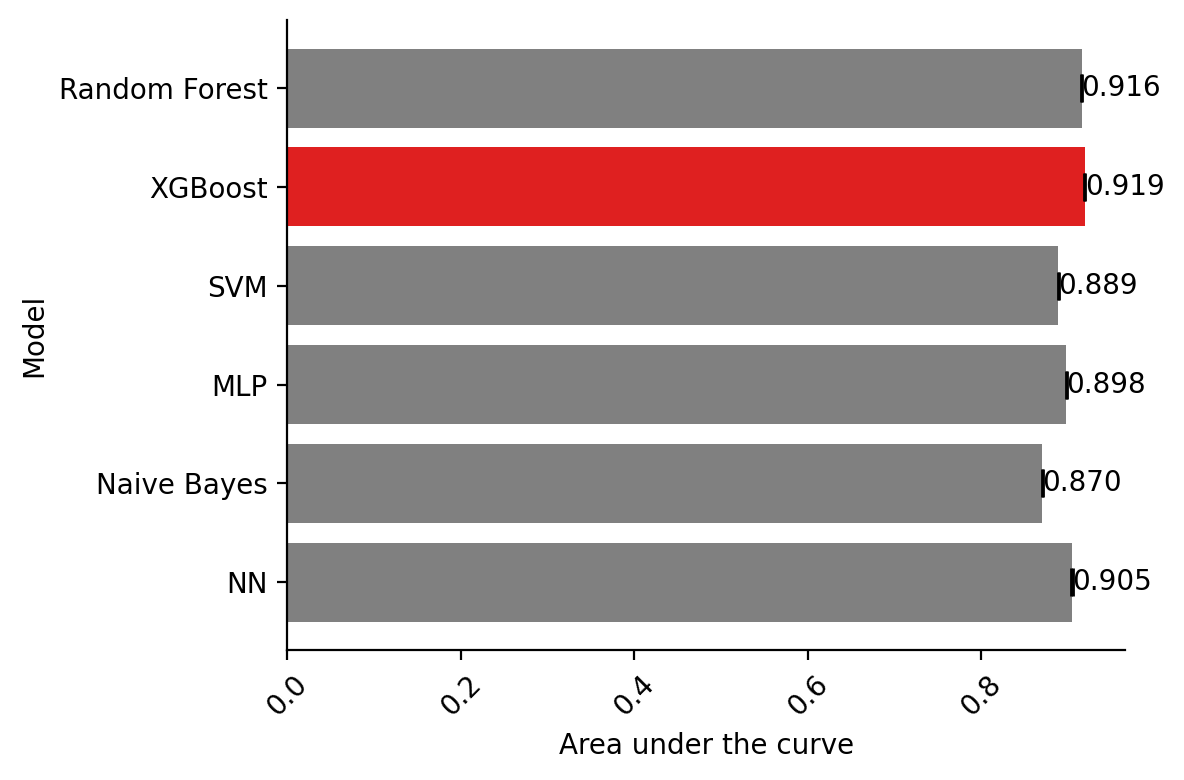

In [43]:
# Plot

colors = ["grey"] * len(auc_df)
colors[auc_df[auc_df["Model"] == "XGBoost"].index[0]] = "red"

# Create barplot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=auc_df, y='Model', x='AUC', ci=None, palette=colors)

# Add AUC values at the tips of the bars
for i, (auc, model) in enumerate(zip(auc_df['AUC'], auc_df['Model'])):
    ax.text(auc, i, f'{auc:.3f}', va='center')

# Add confidence intervals with error bars
auc_values = auc_df['AUC'].values
auc_ci_low = auc_df['AUC_CI_low'].values
auc_ci_high = auc_df['AUC_CI_high'].values
#plt.errorbar(y=range(len(auc_df)), x=auc_values, xerr=[auc_values - auc_ci_low, auc_ci_high - auc_values],
#             fmt='none', color='black', capsize=5)
plt.errorbar(y=range(len(models)), x=auc_values,xerr=[auc_ci_low, auc_ci_high], fmt='none', color='black', capsize=5)
# Customize plot
plt.xticks(rotation=45)
plt.xlabel('Area under the curve')
plt.ylabel('Model')
plt.tight_layout()
sns.despine()
plt.savefig('baseline_model_plot.png', dpi=400)


AUC: 0.9197
Thresh=0.000, n=60, AUC: 0.9197
Thresh=0.003, n=59, AUC: 0.9197
Thresh=0.003, n=58, AUC: 0.9189
Thresh=0.003, n=57, AUC: 0.9203
Thresh=0.003, n=56, AUC: 0.9190
Thresh=0.005, n=55, AUC: 0.9200
Thresh=0.005, n=54, AUC: 0.9208
Thresh=0.005, n=53, AUC: 0.9216
Thresh=0.006, n=52, AUC: 0.9243
Thresh=0.006, n=51, AUC: 0.9225
Thresh=0.006, n=50, AUC: 0.9231
Thresh=0.006, n=49, AUC: 0.9227
Thresh=0.006, n=48, AUC: 0.9204
Thresh=0.006, n=47, AUC: 0.9217
Thresh=0.006, n=46, AUC: 0.9196
Thresh=0.006, n=45, AUC: 0.9197
Thresh=0.006, n=44, AUC: 0.9177
Thresh=0.006, n=43, AUC: 0.9214
Thresh=0.006, n=42, AUC: 0.9232
Thresh=0.006, n=41, AUC: 0.9227
Thresh=0.007, n=40, AUC: 0.9221
Thresh=0.007, n=39, AUC: 0.9202
Thresh=0.007, n=38, AUC: 0.9186
Thresh=0.007, n=37, AUC: 0.9232
Thresh=0.007, n=36, AUC: 0.9248
Thresh=0.007, n=35, AUC: 0.9211
Thresh=0.007, n=34, AUC: 0.9276
Thresh=0.007, n=33, AUC: 0.9243
Thresh=0.007, n=32, AUC: 0.9249
Thresh=0.007, n=31, AUC: 0.9225
Thresh=0.007, n=30, AUC: 0.9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Thresh=0.186, n=1, AUC: 0.7920


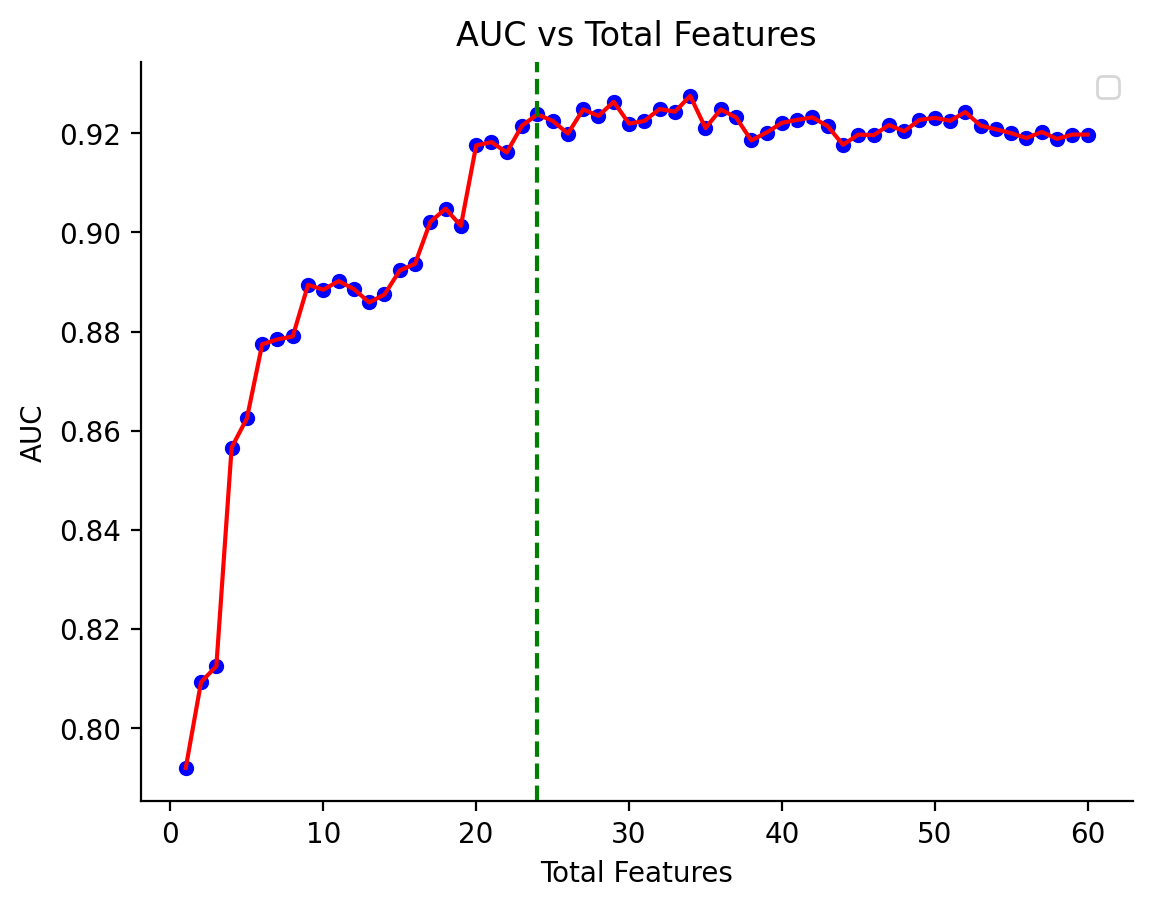

In [50]:
#Use XGboost to get most informative features
#model = XGBClassifier()


#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
#thresholds = np.sort(model.feature_importances_)

#feature_df = pd.DataFrame(columns=['total_features', 'accuracy'])

#for thresh in thresholds:
#    selection = SelectFromModel(model, threshold=thresh, prefit=True)
#    select_X_train = selection.transform(X_train)
#    selection_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
#    selection_model.fit(select_X_train, y_train)
#    select_X_test = selection.transform(X_test)
#    predictions = selection_model.predict(select_X_test)
#    accuracy = accuracy_score(y_test, predictions)
#    feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'accuracy': accuracy*100.0}, ignore_index=True)
#    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class
auc = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc:.4f}")

thresholds = np.sort(model.feature_importances_)

feature_df = pd.DataFrame(columns=['total_features', 'auc'])

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred_proba = selection_model.predict_proba(select_X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    feature_df = feature_df.append({'total_features': select_X_train.shape[1], 'auc': auc}, ignore_index=True)
    print("Thresh=%.3f, n=%d, AUC: %.4f" % (thresh, select_X_train.shape[1], auc))

# Plotting
sns.scatterplot(data=feature_df, x='total_features', y='auc', color='blue')
sns.lineplot(data=feature_df, x='total_features', y='auc', color='red')
plt.xlabel('Total Features')
plt.axvline(x=24, color='green', linestyle='--')
plt.ylabel('AUC')
plt.title('AUC vs Total Features')
plt.legend()

sns.despine()
plt.savefig('top_features_choice_plot.png', dpi=400)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


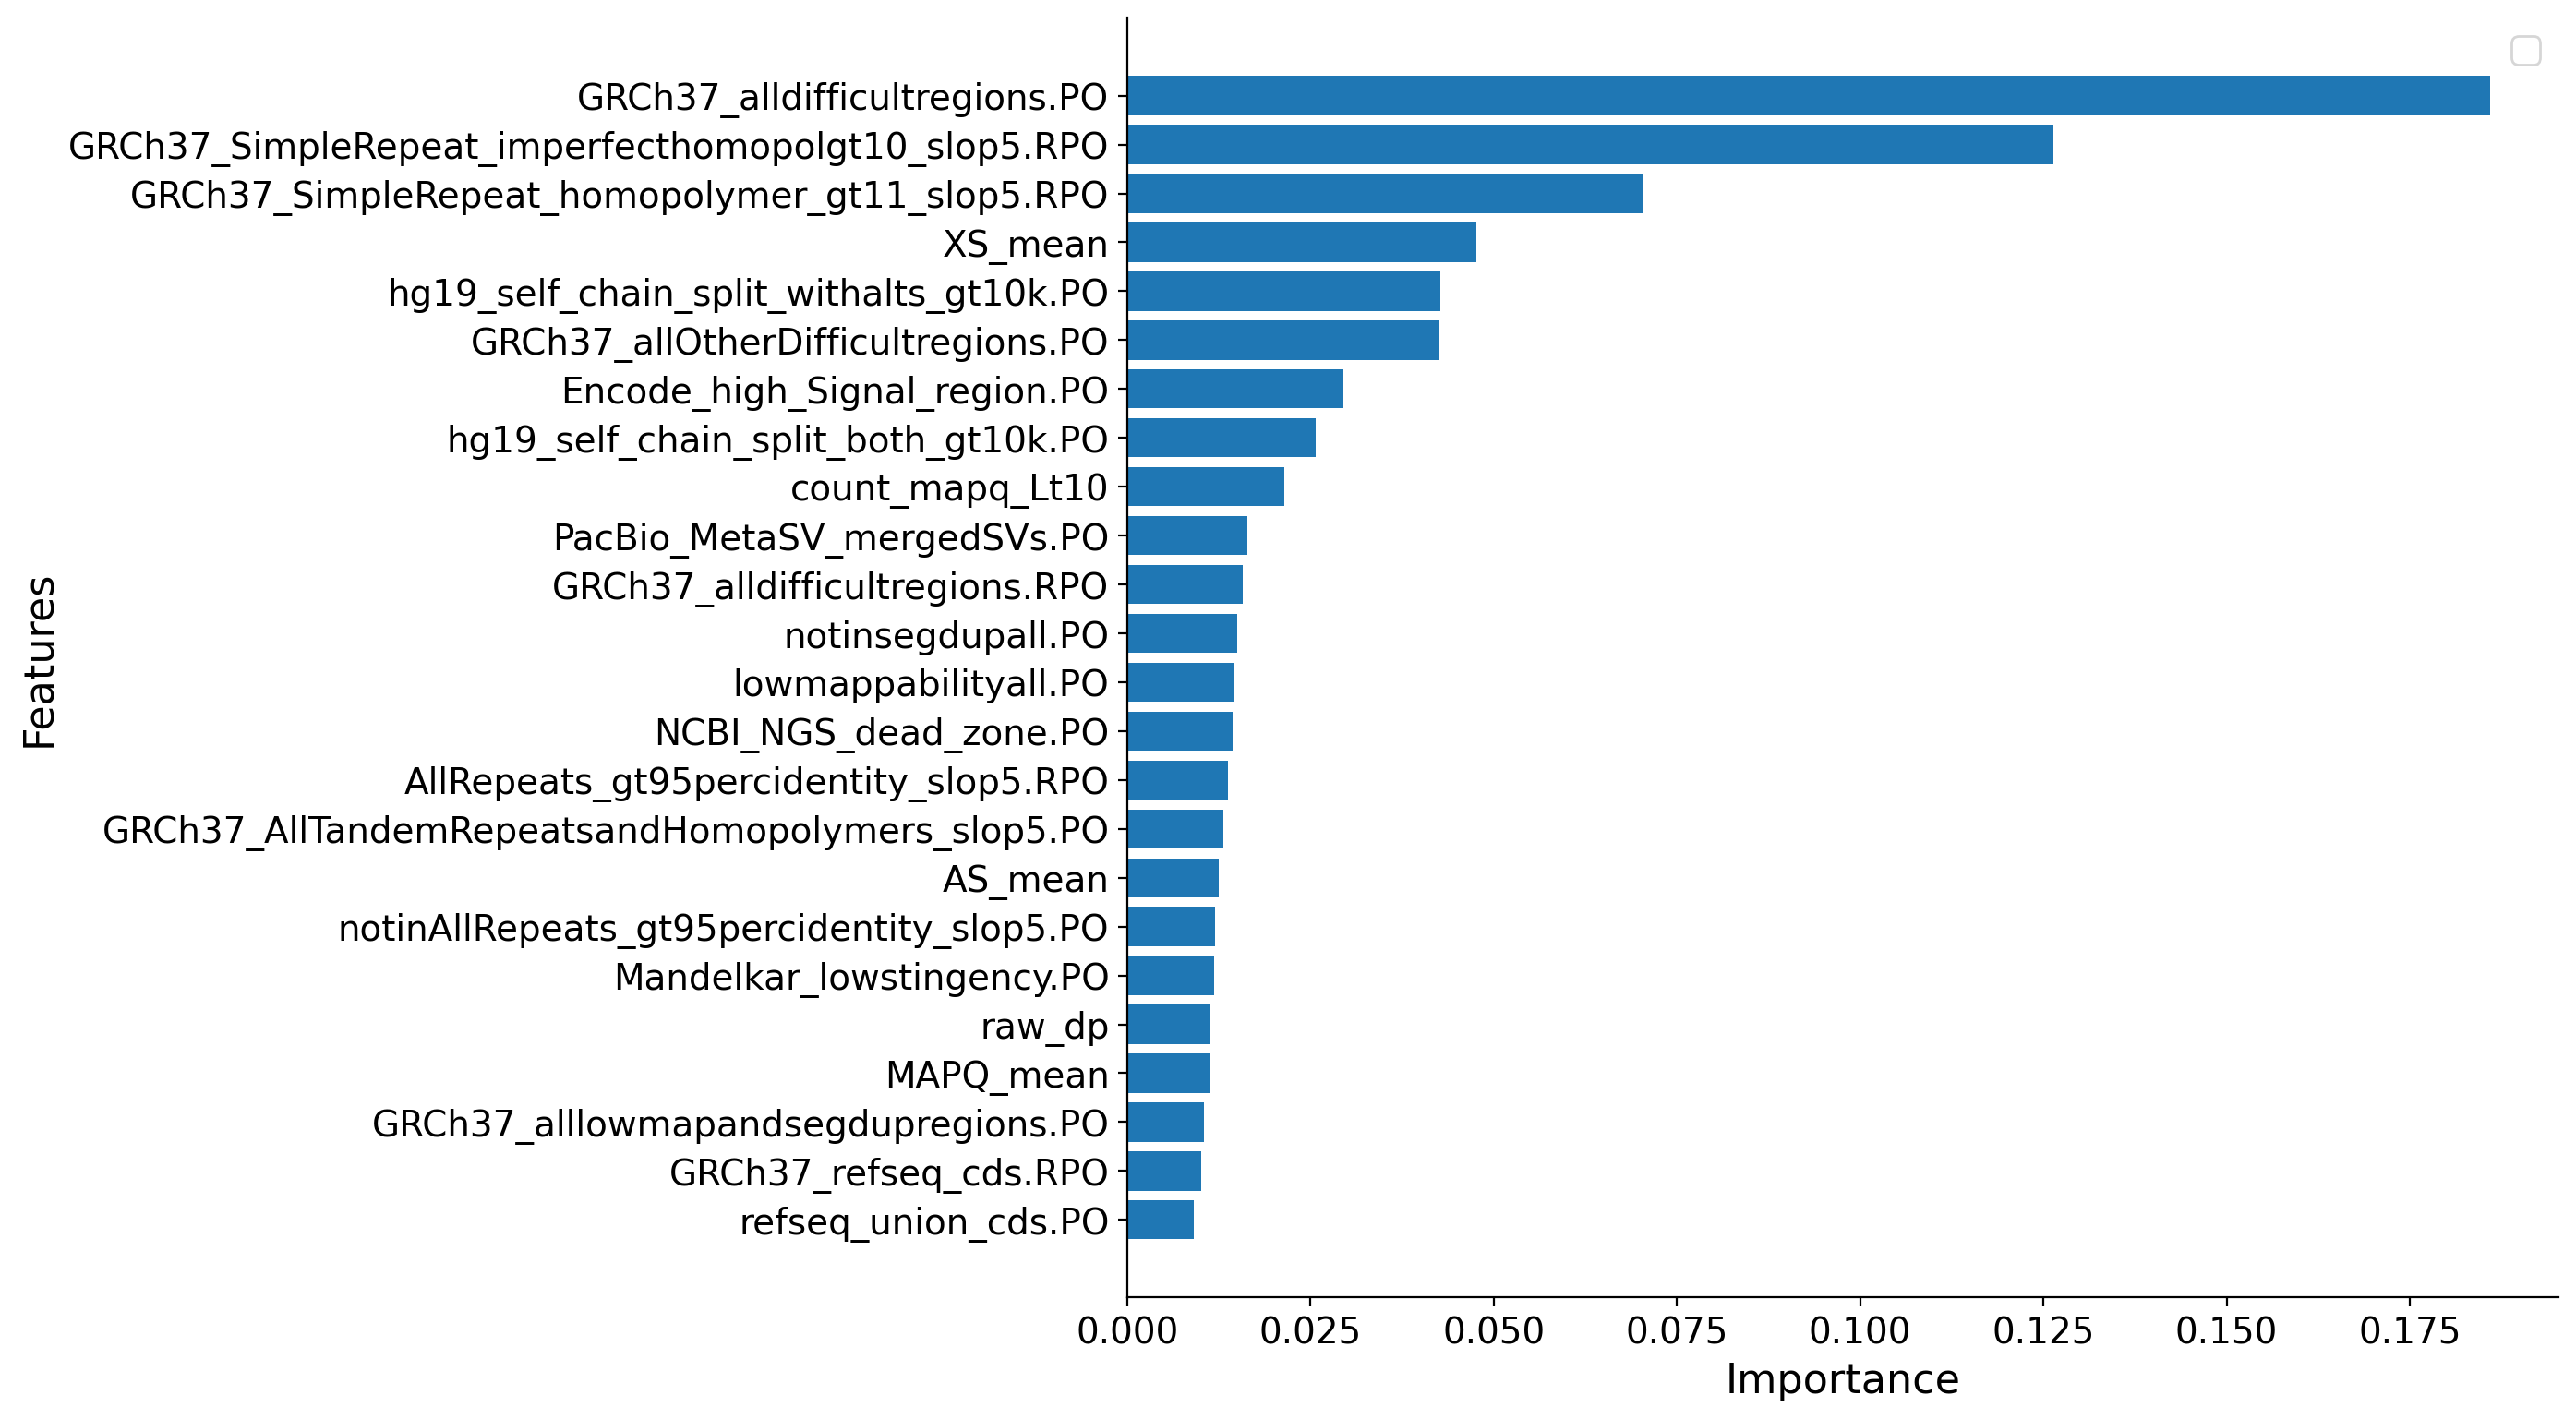

In [61]:

top_indices = np.argsort(model.feature_importances_)[::-1][:24]

# Get the names of the top 26 features based on their indices
top_features = data_filtered_df.columns[top_indices]
cmap = plt.cm.get_cmap('Greys', len(top_features))
# Get the importance scores of the top 26 features
top_importance = model.feature_importances_[top_indices]

# Create a bar plot
plt.figure(figsize=(10, 9))
plt.barh(top_features, top_importance)
#bars = plt.barh(top_features, top_importance, color=[cmap(i) for i in range(len(top_features))])
#plt.xlabel('Importance')
#plt.ylabel('Features')
plt.xlabel('Importance', fontsize=16)  # Adjust fontsize as needed
plt.ylabel('Features', fontsize=16)
#plt.title('Top 26 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
# Adjust x and y axis labels size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
 # Adjust fontsize as needed
sns.despine()
# Show legend
plt.legend(fontsize=14)
plt.show()

In [64]:
data_filtered_top_df = data_filtered_df[top_features]
X_train, X_test, y_train, y_test = preprocess_data(data_filtered_top_df, labels)
#X_train, X_test, y_train, y_test = preprocess_data(data_filtered_df, labels)

In [103]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Choose hyperparameter domain to search over
space = {
    'max_depth': hp.choice('max_depth', np.arange(5, 15, 1, dtype=int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 10000, 10, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(250, 350, 10, dtype=int)),
    'subsample': hp.quniform('subsample', 0.7, 0.9, 0.1),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.3, 0.01),

    'gamma': hp.quniform('gamma', 0, 0.5, 0.05),  # Additional hyperparameter
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-10), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-10), np.log(1)),

    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric': 'error',  # Use 'error' for classification task
}

def score(params):
    model = XGBClassifier(**params)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}  # Minimize negative accuracy (maximize accuracy)
    
def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=150, trials=trials)
    return best

trials = Trials()
best_params = optimize(trials, space)
#XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
#              missing=nan, monotone_constraints='()', n_estimators=100,
#              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
#              reg_alpha=0, reg_lambda=1, ...#)

0.8095655989469065                                                                                                                                                                          
0.8051777095217201                                                                                                                                                                          
  1%|▊                                                                                                                   | 1/150 [00:00<00:48,  3.05trial/s, best loss: -0.8095655989469065]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8051777095217201                                                                                                                                                                          
0.8038613426941641                                                                                                                                                                          
0.8121983326020185                                                                                                                                                                          
  3%|███▊                                                                                                                | 5/150 [00:00<00:24,  5.84trial/s, best loss: -0.8121983326020185]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.800351031154015                                                                                                                                                                           
0.8174637999122422                                                                                                                                                                          
  5%|█████▍                                                                                                              | 7/150 [00:01<00:20,  7.06trial/s, best loss: -0.8174637999122422]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.815269855199649                                                                                                                                                                           
0.8121983326020185                                                                                                                                                                          
  6%|██████▉                                                                                                             | 9/150 [00:01<00:25,  5.50trial/s, best loss: -0.8174637999122422]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8135146994295743                                                                                                                                                                          
0.7999122422114963                                                                                                                                                                          
  7%|████████▍                                                                                                          | 11/150 [00:01<00:20,  6.62trial/s, best loss: -0.8174637999122422]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.7801667397981571                                                                                                                                                                          
0.8038613426941641                                                                                                                                                                          
  9%|█████████▉                                                                                                         | 13/150 [00:02<00:25,  5.39trial/s, best loss: -0.8174637999122422]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.800351031154015                                                                                                                                                                           
0.8121983326020185                                                                                                                                                                          
 10%|███████████▌                                                                                                       | 15/150 [00:02<00:21,  6.37trial/s, best loss: -0.8174637999122422]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8021061869240895                                                                                                                                                                          
 11%|████████████▎                                                                                                      | 16/150 [00:03<00:30,  4.34trial/s, best loss: -0.8174637999122422]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.800351031154015                                                                                                                                                                           
0.8086880210618692                                                                                                                                                                          
0.797718297498903                                                                                                                                                                           
 13%|██████████████▌                                                                                                    | 19/150 [00:03<00:21,  6.20trial/s, best loss: -0.8174637999122422]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8034225537516455                                                                                                                                                                          
0.8271171566476525                                                                                                                                                                          
 14%|████████████████                                                                                                   | 21/150 [00:03<00:23,  5.40trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8222904782799474                                                                                                                                                                          
0.8174637999122422                                                                                                                                                                          
 15%|█████████████████▋                                                                                                 | 23/150 [00:04<00:18,  7.01trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8121983326020185                                                                                                                                                                          
0.8271171566476525                                                                                                                                                                          
 17%|███████████████████▏                                                                                               | 25/150 [00:04<00:21,  5.78trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8082492321193506                                                                                                                                                                          
0.8187801667397981                                                                                                                                                                          
 18%|████████████████████▋                                                                                              | 27/150 [00:04<00:18,  6.50trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8271171566476525                                                                                                                                                                          
0.813953488372093                                                                                                                                                                           
 19%|██████████████████████▏                                                                                            | 29/150 [00:05<00:23,  5.10trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8218516893374287                                                                                                                                                                          
0.8135146994295743                                                                                                                                                                          
 21%|███████████████████████▊                                                                                           | 31/150 [00:05<00:20,  5.83trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8082492321193506                                                                                                                                                                          
0.824045634050022                                                                                                                                                                           
 22%|█████████████████████████▎                                                                                         | 33/150 [00:06<00:23,  4.98trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8253620008775779                                                                                                                                                                          
0.8148310662571303                                                                                                                                                                          
 23%|██████████████████████████▊                                                                                        | 35/150 [00:06<00:19,  6.01trial/s, best loss: -0.8271171566476525]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.7968407196138657                                                                                                                                                                          
0.8284335234752084                                                                                                                                                                          
 25%|████████████████████████████▎                                                                                      | 37/150 [00:06<00:22,  5.00trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8157086441421676                                                                                                                                                                          
 25%|█████████████████████████████▏                                                                                     | 38/150 [00:07<00:20,  5.51trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8157086441421676                                                                                                                                                                          
0.8029837648091268                                                                                                                                                                          
 27%|██████████████████████████████▋                                                                                    | 40/150 [00:07<00:22,  4.84trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8034225537516455                                                                                                                                                                          
0.8025449758666081                                                                                                                                                                          
 28%|████████████████████████████████▏                                                                                  | 42/150 [00:07<00:18,  5.90trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.7968407196138657                                                                                                                                                                          
0.8113207547169812                                                                                                                                                                          
 29%|█████████████████████████████████▋                                                                                 | 44/150 [00:08<00:21,  4.88trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8143922773146117                                                                                                                                                                          
0.8038613426941641                                                                                                                                                                          
 31%|███████████████████████████████████▎                                                                               | 46/150 [00:08<00:16,  6.13trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8029837648091268                                                                                                                                                                          
0.7841158402808249                                                                                                                                                                          
 32%|████████████████████████████████████▊                                                                              | 48/150 [00:09<00:19,  5.18trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8179025888547609                                                                                                                                                                          
 33%|█████████████████████████████████████▌                                                                             | 49/150 [00:09<00:17,  5.80trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.797718297498903                                                                                                                                                                           
0.8082492321193506                                                                                                                                                                          
 34%|███████████████████████████████████████                                                                            | 51/150 [00:09<00:19,  4.97trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.7946467749012724                                                                                                                                                                          
0.8025449758666081                                                                                                                                                                          
 35%|████████████████████████████████████████▋                                                                          | 53/150 [00:09<00:15,  6.14trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8117595436594998                                                                                                                                                                          
0.8266783677051338                                                                                                                                                                          
 37%|██████████████████████████████████████████▏                                                                        | 55/150 [00:10<00:18,  5.08trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8148310662571303                                                                                                                                                                          
0.8183413777972796                                                                                                                                                                          
 38%|███████████████████████████████████████████▋                                                                       | 57/150 [00:10<00:15,  6.15trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8073716542343133                                                                                                                                                                          
0.799034664326459                                                                                                                                                                           
 39%|█████████████████████████████████████████████▏                                                                     | 59/150 [00:11<00:18,  4.84trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8161474330846863                                                                                                                                                                          
0.8034225537516455                                                                                                                                                                          
 41%|██████████████████████████████████████████████▊                                                                    | 61/150 [00:11<00:15,  5.68trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8271171566476525                                                                                                                                                                          
0.8135146994295743                                                                                                                                                                          
 42%|████████████████████████████████████████████████▎                                                                  | 63/150 [00:12<00:18,  4.63trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8078104431768319                                                                                                                                                                          
0.8007898200965335                                                                                                                                                                          
 43%|█████████████████████████████████████████████████▊                                                                 | 65/150 [00:12<00:15,  5.60trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8271171566476525                                                                                                                                                                          
0.8271171566476525                                                                                                                                                                          
 45%|███████████████████████████████████████████████████▎                                                               | 67/150 [00:12<00:17,  4.76trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8284335234752084                                                                                                                                                                          
0.8284335234752084                                                                                                                                                                          
 46%|████████████████████████████████████████████████████▉                                                              | 69/150 [00:13<00:13,  6.06trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8284335234752084                                                                                                                                                                          
0.8165862220272049                                                                                                                                                                          
 47%|██████████████████████████████████████████████████████▍                                                            | 71/150 [00:13<00:15,  5.18trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8275559455901711                                                                                                                                                                          
0.8196577446248354                                                                                                                                                                          
 49%|███████████████████████████████████████████████████████▉                                                           | 73/150 [00:13<00:12,  6.28trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8249232119350592                                                                                                                                                                          
0.813953488372093                                                                                                                                                                           
 50%|█████████████████████████████████████████████████████████▌                                                         | 75/150 [00:14<00:14,  5.01trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.824045634050022                                                                                                                                                                           
0.8038613426941641                                                                                                                                                                          
 51%|███████████████████████████████████████████████████████████                                                        | 77/150 [00:14<00:11,  6.16trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8187801667397981                                                                                                                                                                          
0.8121983326020185                                                                                                                                                                          
 53%|████████████████████████████████████████████████████████████▌                                                      | 79/150 [00:15<00:14,  4.96trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8043001316366828                                                                                                                                                                          
0.8271171566476525                                                                                                                                                                          
 54%|██████████████████████████████████████████████████████████████                                                     | 81/150 [00:15<00:11,  5.83trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.812637121544537                                                                                                                                                                           
0.8148310662571303                                                                                                                                                                          
 55%|███████████████████████████████████████████████████████████████▋                                                   | 83/150 [00:15<00:13,  4.94trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8117595436594998                                                                                                                                                                          
0.8266783677051338                                                                                                                                                                          
 57%|█████████████████████████████████████████████████████████████████▏                                                 | 85/150 [00:16<00:10,  6.38trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8117595436594998                                                                                                                                                                          
0.812637121544537                                                                                                                                                                           
 58%|██████████████████████████████████████████████████████████████████▋                                                | 87/150 [00:16<00:11,  5.68trial/s, best loss: -0.8284335234752084]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8315050460728389                                                                                                                                                                          
0.8161474330846863                                                                                                                                                                          
 59%|████████████████████████████████████████████████████████████████████▏                                              | 89/150 [00:16<00:09,  6.63trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.815269855199649                                                                                                                                                                           
0.8143922773146117                                                                                                                                                                          
 61%|█████████████████████████████████████████████████████████████████████▊                                             | 91/150 [00:17<00:11,  5.25trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8078104431768319                                                                                                                                                                          
0.7832382623957876                                                                                                                                                                          
 61%|██████████████████████████████████████████████████████████████████████▌                                            | 92/150 [00:17<00:09,  5.97trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.812637121544537                                                                                                                                                                           
0.806494076349276                                                                                                                                                                           
 63%|████████████████████████████████████████████████████████████████████████▊                                          | 95/150 [00:18<00:09,  5.97trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8100043878894252                                                                                                                                                                          
0.8121983326020185                                                                                                                                                                          
 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 96/150 [00:18<00:08,  6.59trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8187801667397981                                                                                                                                                                          
0.8007898200965335                                                                                                                                                                          
 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 99/150 [00:18<00:08,  6.04trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8284335234752084                                                                                                                                                                          
 67%|████████████████████████████████████████████████████████████████████████████                                      | 100/150 [00:18<00:07,  6.55trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8284335234752084                                                                                                                                                                          
0.8143922773146117                                                                                                                                                                          
 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 102/150 [00:19<00:08,  5.74trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8170250109697236                                                                                                                                                                          
0.790258885476086                                                                                                                                                                           
 69%|███████████████████████████████████████████████████████████████████████████████                                   | 104/150 [00:19<00:06,  6.90trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8121983326020185                                                                                                                                                                          
0.7968407196138657                                                                                                                                                                          
 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 106/150 [00:19<00:07,  5.94trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.813953488372093                                                                                                                                                                           
0.8275559455901711                                                                                                                                                                          
 72%|██████████████████████████████████████████████████████████████████████████████████                                | 108/150 [00:20<00:05,  7.33trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8293111013602458                                                                                                                                                                          
0.812637121544537                                                                                                                                                                           
 73%|███████████████████████████████████████████████████████████████████████████████████▌                              | 110/150 [00:20<00:07,  5.45trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8157086441421676                                                                                                                                                                          
 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 111/150 [00:20<00:06,  5.74trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8161474330846863                                                                                                                                                                          
0.812637121544537                                                                                                                                                                           
 75%|█████████████████████████████████████████████████████████████████████████████████████▉                            | 113/150 [00:21<00:07,  4.74trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.812637121544537                                                                                                                                                                           
0.8161474330846863                                                                                                                                                                          
 77%|███████████████████████████████████████████████████████████████████████████████████████▍                          | 115/150 [00:21<00:06,  5.59trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8034225537516455                                                                                                                                                                          
0.8113207547169812                                                                                                                                                                          
 78%|████████████████████████████████████████████████████████████████████████████████████████▉                         | 117/150 [00:22<00:06,  4.82trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8249232119350592                                                                                                                                                                          
0.813953488372093                                                                                                                                                                           
 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/150 [00:22<00:05,  5.85trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8130759104870557                                                                                                                                                                          
0.800351031154015                                                                                                                                                                           
 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 121/150 [00:22<00:06,  4.75trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8113207547169812                                                                                                                                                                          
0.8012286090390522                                                                                                                                                                          
 82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 123/150 [00:23<00:04,  5.56trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8021061869240895                                                                                                                                                                          
0.8043001316366828                                                                                                                                                                          
 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 125/150 [00:23<00:05,  4.69trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8034225537516455                                                                                                                                                                          
0.8192189556823168                                                                                                                                                                          
 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 127/150 [00:24<00:03,  5.78trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8007898200965335                                                                                                                                                                          
0.813953488372093                                                                                                                                                                           
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 129/150 [00:24<00:04,  4.74trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8121983326020185                                                                                                                                                                          
0.8034225537516455                                                                                                                                                                          
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌              | 131/150 [00:24<00:03,  5.92trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.806494076349276                                                                                                                                                                           
0.8095655989469065                                                                                                                                                                          
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████             | 133/150 [00:25<00:03,  4.82trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8174637999122422                                                                                                                                                                          
0.8100043878894252                                                                                                                                                                          
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 135/150 [00:25<00:02,  5.85trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.7981570864414217                                                                                                                                                                          
0.8200965335673541                                                                                                                                                                          
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 137/150 [00:26<00:02,  4.93trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8038613426941641                                                                                                                                                                          
0.8275559455901711                                                                                                                                                                          
 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 139/150 [00:26<00:01,  6.55trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8021061869240895                                                                                                                                                                          
0.8121983326020185                                                                                                                                                                          
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 141/150 [00:26<00:01,  5.70trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8117595436594998                                                                                                                                                                          
0.8209741114523914                                                                                                                                                                          
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 143/150 [00:27<00:01,  6.68trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8293111013602458                                                                                                                                                                          
0.8029837648091268                                                                                                                                                                          
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 145/150 [00:27<00:00,  5.75trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8293111013602458                                                                                                                                                                          
0.8275559455901711                                                                                                                                                                          
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 147/150 [00:27<00:00,  7.02trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8183413777972796                                                                                                                                                                          
0.8275559455901711                                                                                                                                                                          
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149/150 [00:28<00:00,  5.76trial/s, best loss: -0.8315050460728389]

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



0.8236068451075033                                                                                                                                                                          
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.31trial/s, best loss: -0.8315050460728389]


/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



In [104]:
best_params

{'colsample_bytree': 0.7000000000000001,
 'gamma': 0.25,
 'learning_rate': 0.27,
 'max_depth': 1,
 'min_child_weight': 0,
 'n_estimators': 460,
 'reg_alpha': 1.9840885426002516e-05,
 'reg_lambda': 0.9899759867459348,
 'subsample': 0.9}

In [106]:
def evaluate_xgboost_model(X_train, X_test, y_train, y_test, xg_best_trial_params):
    final_xg_model = XGBClassifier(**xg_best_trial_params)
    final_xg_model.fit(X_train, y_train)
    
    # Predict classes
    y_pred_train = final_xg_model.predict(X_train)
    y_pred_test = final_xg_model.predict(X_test)
    
    # Calculate accuracy on training and test sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Save the trained model
    joblib.dump(final_xg_model, "best_xgb_model.NEW.joblib")
    
    return train_accuracy, test_accuracy

train_accuracy, test_accuracy = evaluate_xgboost_model(X_train, X_test, y_train, y_test, best_params)
test_accuracy

0.8459850811759544

In [92]:
data_test_df = pd.read_csv("../paper_analysis/SangerVariants_VerSamples_IDTProbes_NGS82-VE070_hom0_random200probes_variants.csv")
data_test_cols_df = data_test_df[model_cols]

data_test_cols_df = data_test_cols_df.fillna(0)
data_test_cols_df = data_test_cols_df[top_features]
min_max_scaler = preprocessing.MinMaxScaler()
test_scaled_df = pd.DataFrame(min_max_scaler.fit_transform(data_test_cols_df.values),
                              columns=data_test_cols_df.columns, index=data_test_cols_df.index)

test_data = test_scaled_df.values


loaded_model = joblib.load("best_xgb_model.NEW.joblib")
predictions = loaded_model.predict(test_data).tolist()
pred_probabilities = loaded_model.predict_proba(test_data).tolist()
data_test_df['prob_pred_1'] = [prob[1] for prob in pred_probabilities]
data_test_df['prob_pred_0'] = [prob[0] for prob in pred_probabilities]
data_test_df['prediction'] = predictions

#data_test_df.to_csv('SangerVariants_VerSamples_IDTProbes.400data.resutls.csv')

In [93]:
data_test_df[['homology', 'prob_pred_1']]
homology = data_test_df['homology']
predictions = data_test_df['prob_pred_1']

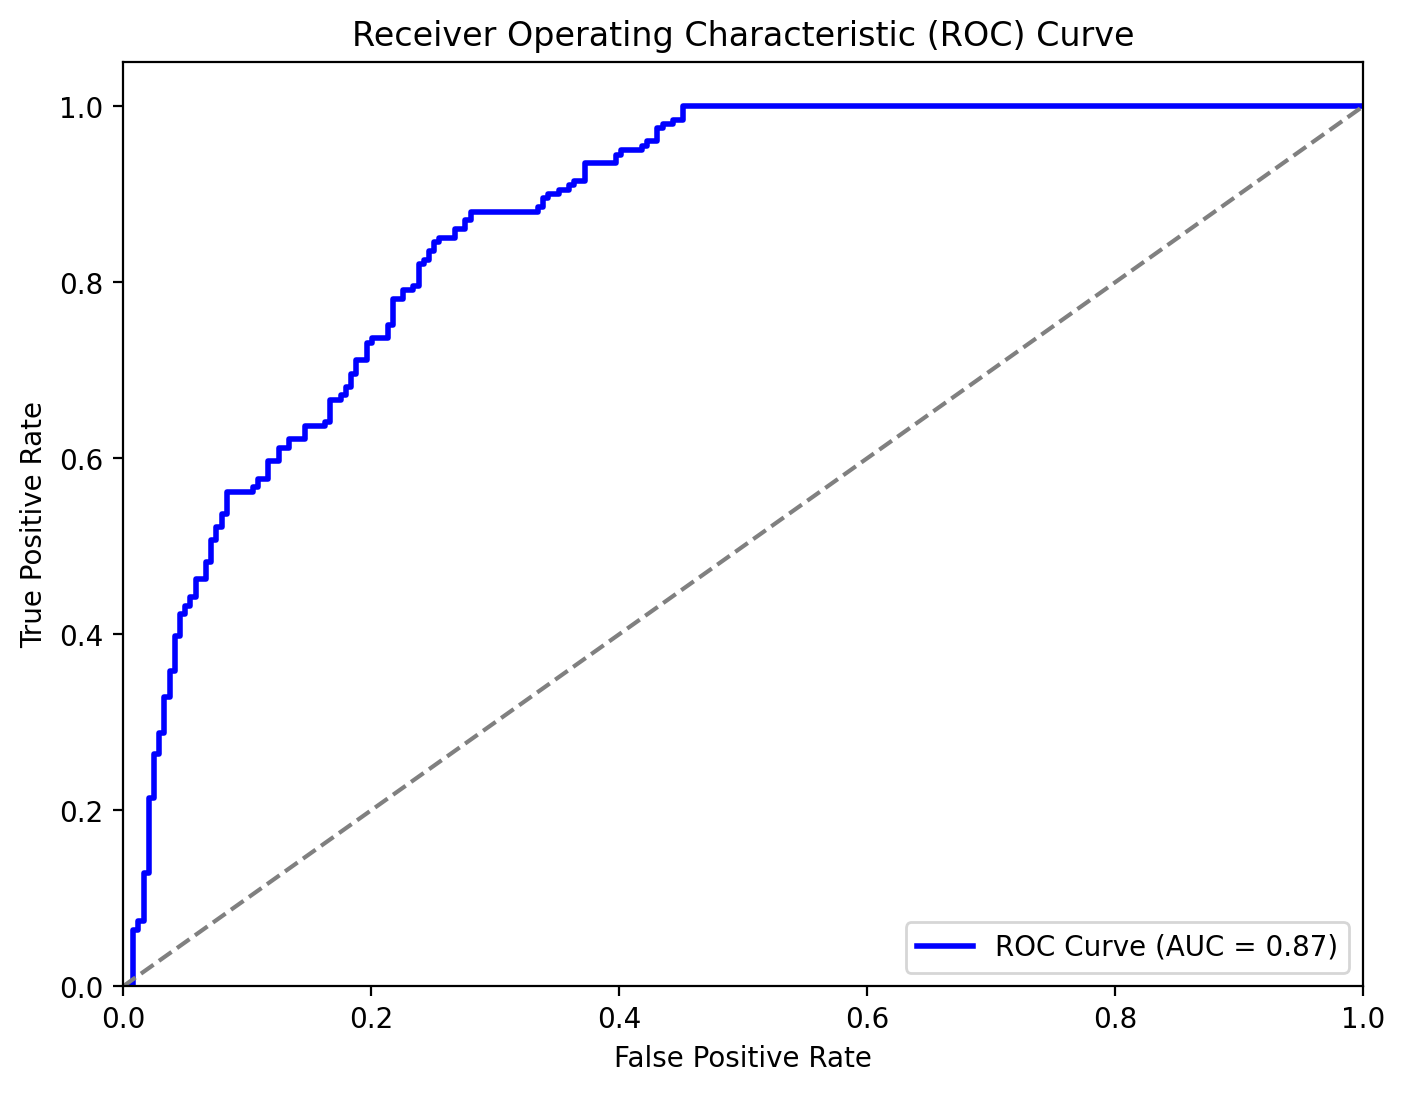

In [94]:
#Calculate ROC curve
fpr, tpr, thresholds = roc_curve(homology, predictions)

# Calculate AUC score
auc_score = roc_auc_score(homology, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/rohan/anaconda3/envs/esmfold/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/rohan/ana

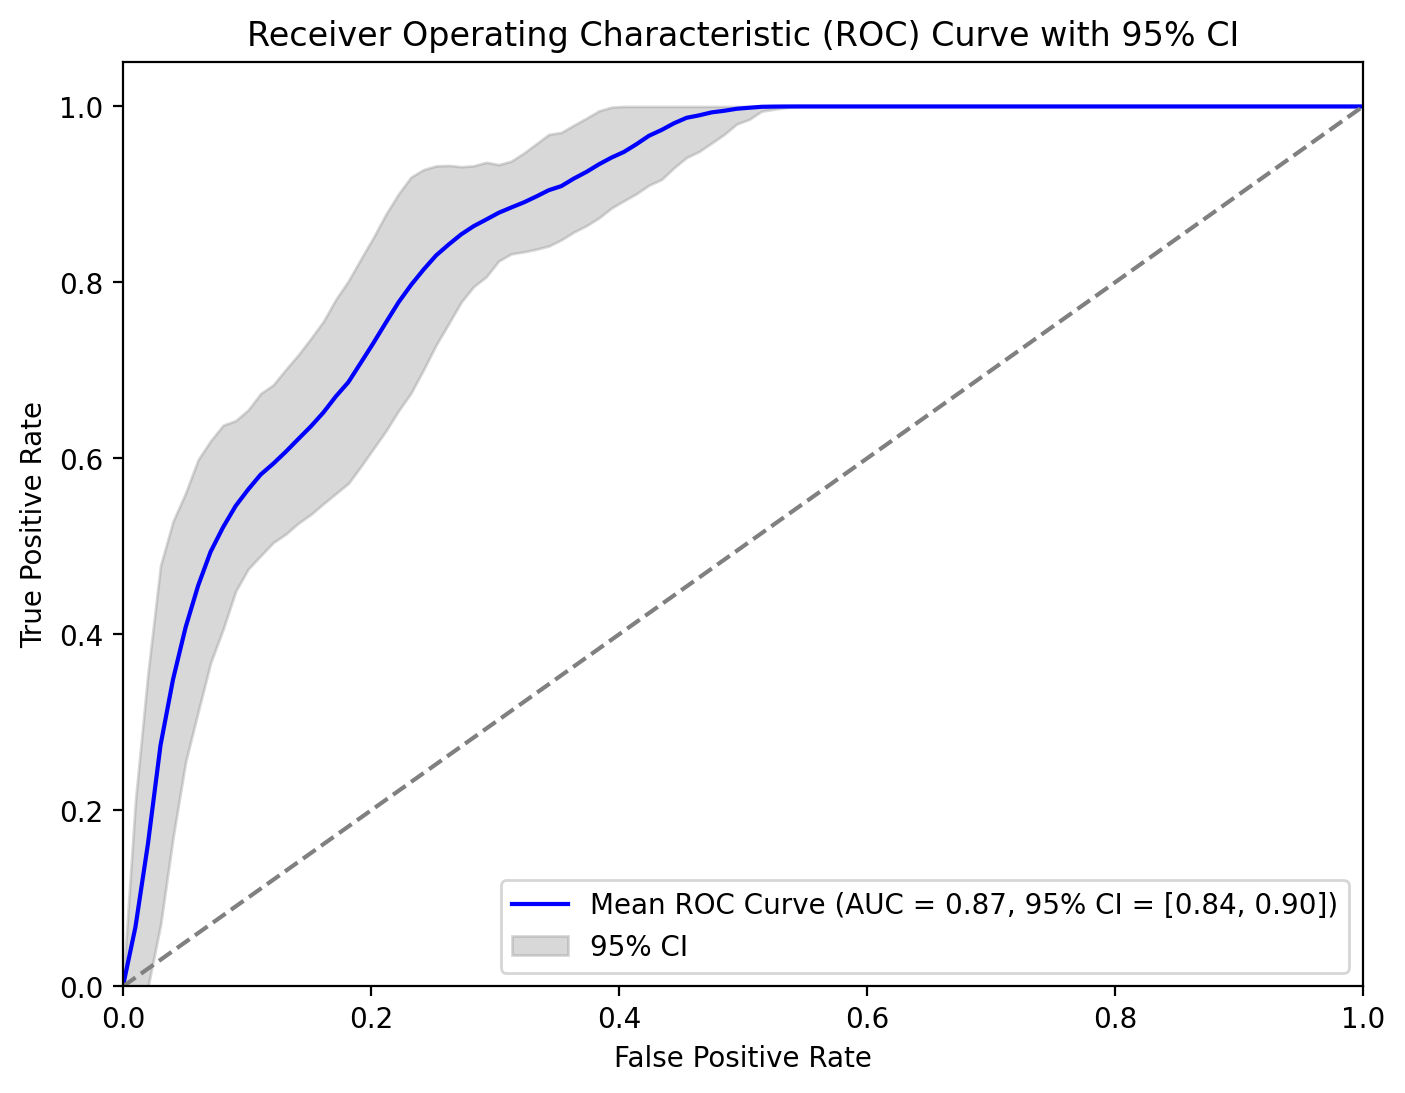

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc_with_ci(y_true, y_pred, n_bootstraps=100):
    # Compute ROC curve and ROC area for each bootstrap
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for _ in range(n_bootstraps):
        # Bootstrap sample
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        fpr, tpr, _ = roc_curve(y_true[idx], y_pred[idx])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # Interpolate ROC curve to average FPR points
        interp_tpr = interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    
    # Compute mean and CI of ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)
    
    # Compute mean AUC and CI
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    auc_ci = (mean_auc - 1.96 * std_auc, mean_auc + 1.96 * std_auc)
    
    # Plot ROC curve with CI
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC Curve (AUC = {mean_auc:.2f}, 95% CI = [{auc_ci[0]:.2f}, {auc_ci[1]:.2f}])')
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3, label='95% CI')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve with 95% CI')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
plot_roc_with_ci(homology, predictions)

In [88]:
sensitivity = tpr
specificity = 1 - fpr

# Calculate Youden's J statistic for each threshold
youden_j = sensitivity + specificity - 1

# Find the index of the threshold that maximizes Youden's J statistic
best_threshold_index = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_index]

# Calculate predictions at the best threshold
predictions_at_best_threshold = (predictions >= best_threshold).astype(int)

# Calculate accuracy at the best threshold
accuracy_at_best_threshold = accuracy_score(homology, predictions_at_best_threshold)

print("Accuracy at Best Threshold:", accuracy_at_best_threshold)

Accuracy at Best Threshold: 0.7931818181818182


In [96]:
data_result_df = data_test_df.copy()
data_result_df = data_result_df.drop(['prob_pred_0', 'prediction'], axis=1)
data_result_df['predictions'] = data_result_df['prob_pred_1'].apply(lambda x: 1 if x > 0.79318 else 0)
data_result_df.predictions.value_counts()

0    241
1    199
Name: predictions, dtype: int64

In [108]:
data_result_df.to_csv("SangerVariants_VerSamples_IDTProbes.400data.resutls.csv", index=None)